In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

from tqdm import tqdm

from scipy.linalg import eigh, norm, expm
from scipy.optimize import curve_fit

In [2]:
def Ham_ST(N,eps_a,eps_b,eps_c,t_ab,t_bb,t_bc,omega0,g,n_site):
    
    H = np.diag([eps_a/2,eps_b/2,eps_c/2]*N + [omega0/2])
    H += np.diag([-t_ab,-t_bc,0]*(N-1) + [-t_ab,-t_bc] + [0],k=1)
    H += np.diag([0,-t_bb,0]*(N-1) + [0],k=3)

    H[1,n-2] -= t_bb
    H[-1,n_site] -= g

    H += np.conjugate(H.transpose())
    
    return H

In [3]:
def time_evol(t,H):

    psi_in = np.array([0.]*n + [1.])
    pop = []
    phot = np.zeros((n,len(t)),dtype=np.complex128)

    for i in tqdm(np.arange(0,len(t),1)):
        temp = (expm(-1.j*H*t[i])@psi_in)
        phot[:,i] = temp[:-1]
        pop.append(temp[-1])
    
    return pop, phot

# A quantum emitter coupled to the assignment lattice

In [4]:
N = 200 #number of primitive cells
n = 3*N #number of points

# On-site energies
eps_a = eps_c = 4.
eps_b = 0.

# Hopping terms
t_bb = 1
t_ab = 2
t_bc = 2

## Coupling to an A site

We couple the atom to an A site using the hamiltonian
\begin{equation}
    H = g \, (\sigma^+ a_n + \sigma^- a_n^{\dagger})
\end{equation}
where $\sigma^{+(-)}$ are the two-level atom (TLA) ladder operators and $a_n$ is the annihilation operator of a field excitation in the n-th A-site. 

We choose here the transition frequency of the atom ($\omega_0$) and the coupling strenght $g$.

In [5]:
omega0 = 4.0 #atom frequency
g = 0.1 #atom-cavity coupling

In [6]:
H = Ham_ST(N,eps_a,eps_b,eps_c,t_ab,t_bb,t_bc,omega0,g,n//2)

In [7]:
eigvals, eigvect = eigh(H)

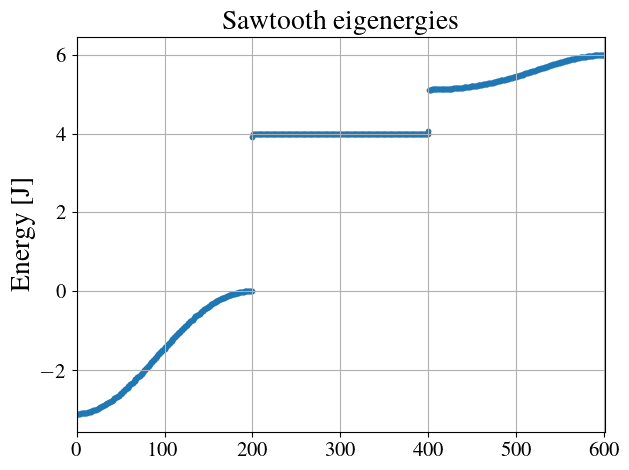

In [8]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
#plt.savefig("spectrum_sawtooth.png")
plt.show()

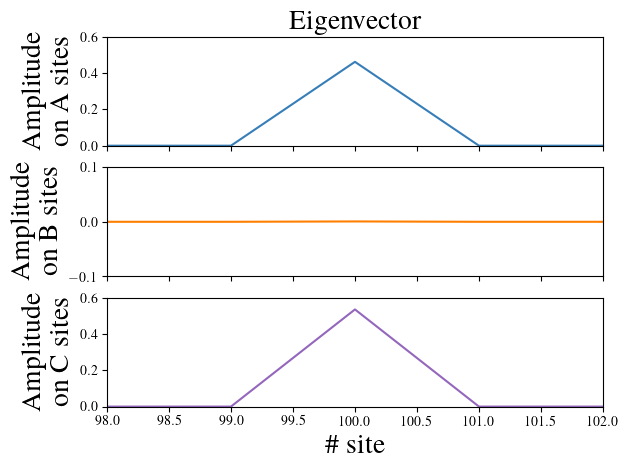

In [19]:
fig, ax = plt.subplots(nrows=3,ncols=1,sharex=True)

s = 400
bs = eigvect[:-1,s]/norm(eigvect[:-1,s])
ax[0].plot(bs[::3]**2,color="#377eb8")
ax[1].plot(bs[1::3]**2,color='#ff7f00')
ax[2].plot(bs[2::3]**2,color='C4')

ax[0].set_title("Eigenvector",fontsize=20)
ax[2].set_xlabel("\# site",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)
ax[2].set_ylabel("Amplitude \n on C sites",fontsize=20)

ax[2].set_xlim(98,102)
ax[1].set_ylim(-0.1,0.1)
ax[0].set_ylim(0,0.6)
ax[2].set_ylim(0,0.6)

#plt.savefig("eig_FB.pdf")
plt.show()

We calculate the state
\begin{equation}
    |\Psi(t)\rangle = e^{-i\,H\,t} |e,vac\rangle
\end{equation}

In [21]:
t = np.linspace(0,60,100)
pop, phot = time_evol(t,H)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.30it/s]


We plot here the time evolution of the atomic part of the wavefunction.

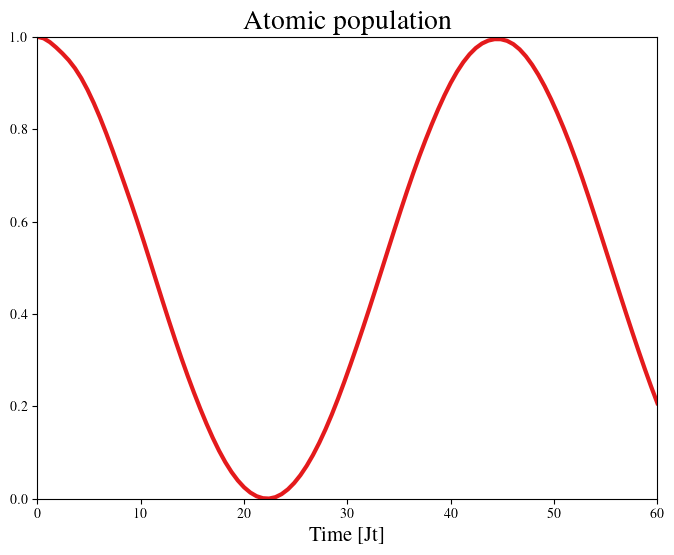

In [23]:
fig = plt.figure(figsize=(8,6))

pop_at = np.real(pop*np.conjugate(pop))
plt.plot(t,pop_at,c='#e41a1c',lw=3,label="Data")

plt.title(f"Atomic population",fontsize=20)
plt.xlabel("Time [Jt]",fontsize=15)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("time-evol/at_A_resFB.png")
plt.show()

In [24]:
np.where(pop_at == min(pop_at[:100]))

(array([37], dtype=int64),)

In [25]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

In [26]:
vec = [20,37,80]

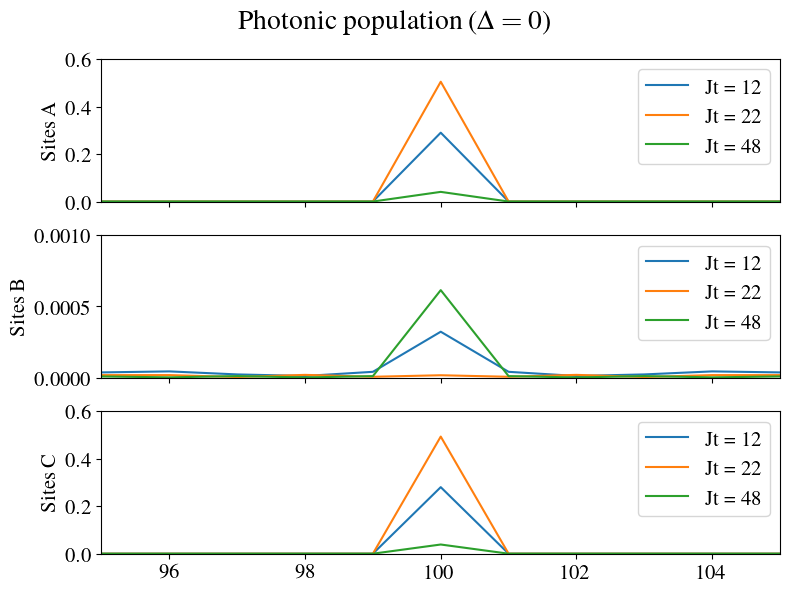

In [32]:
fig, ax = plt.subplots(figsize=(8,6),nrows=3,ncols=1,sharex=True,tight_layout=0)

for s in vec:
    ax[0].plot(pop_phot[::3,s],label=f"Jt = {t[s]:.0f}")
    ax[1].plot(pop_phot[1::3,s],label=f"Jt = {t[s]:.0f}")
    ax[2].plot(pop_phot[2::3,s],label=f"Jt = {t[s]:.0f}")

plt.suptitle(f"Photonic population ($\Delta = 0$)",fontsize=20)
#plt.xlabel("\# Site",fontsize=20)

#plt.xlim(95,104)
ax[0].set_ylabel("Sites A",fontsize=15)
ax[1].set_ylabel("Sites B",fontsize=15)
ax[2].set_ylabel("Sites C",fontsize=15)

ax[0].set_ylim(0,0.6)
ax[1].set_ylim(0,1e-3)
ax[2].set_ylim(0,0.6)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)

ax[2].set_xlim(95,105)


plt.savefig("time-evol/phot_A_resFB.png")

plt.show()

## Coupling to an B site

We couple the atom to a B site using the hamiltonian
\begin{equation}
    H = g \, (\sigma^+ b_n + \sigma^- b_n^{\dagger})
\end{equation}
where $\sigma^{+(-)}$ are the two-level atom (TLA) ladder operators and $b_n$ is the annihilation operator of a field excitation in the n-th B-site. 

In [68]:
omega0 = 5.1 #atom frequency
g = 0.1 #atom-cavity coupling

In [69]:
H = Ham_ST(N,eps_a,eps_b,eps_c,t_ab,t_bb,t_bc,omega0,g,n//2 + 1)

In [70]:
eigvals, eigvect = eigh(H)

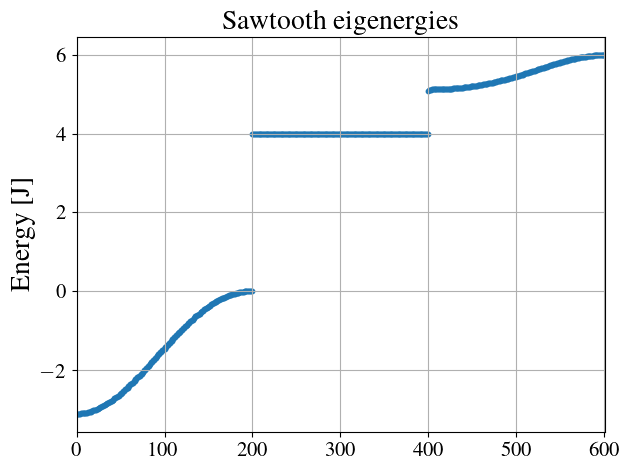

In [71]:
fig, ax = plt.subplots(tight_layout=True)

ax.scatter(np.arange(len(eigvals)),eigvals,s=10)

ax.set_title("Sawtooth eigenergies",fontsize=20)
ax.set_ylabel(r"Energy [J]",fontsize=20)

ax.set_xlim(0,len(eigvals))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid()
#plt.savefig("spectrum_sawtooth.png")
plt.show()

We calculate the state
\begin{equation}
    |\Psi(t)\rangle = e^{-i\,H\,t} |e,vac\rangle
\end{equation}

In [72]:
t = np.linspace(0,80,150)
pop, phot = time_evol(t,H)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [01:10<00:00,  2.13it/s]


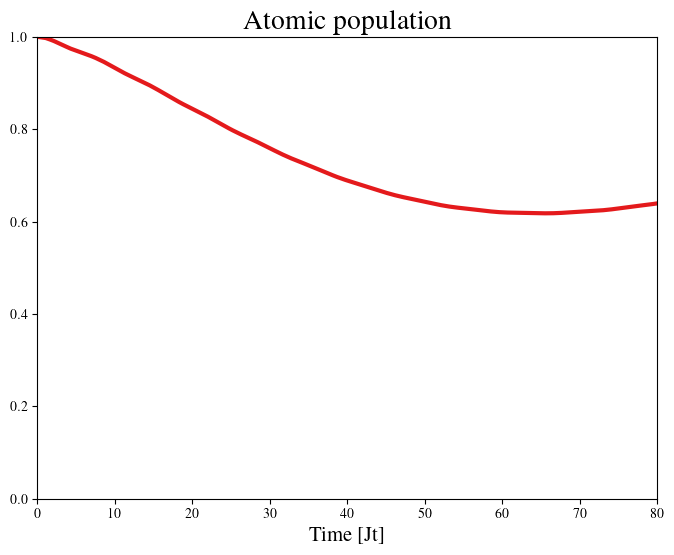

In [73]:
fig = plt.figure(figsize=(8,6))

pop_at = np.real(pop*np.conjugate(pop))
plt.plot(t,pop_at,c='#e41a1c',lw=3,label="Data")

plt.title(f"Atomic population",fontsize=20)
plt.xlabel("Time [Jt]",fontsize=15)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#plt.savefig(f"plots/Asite/at_A_{omega0*100:.0f}.png")
plt.show()

In [74]:
pop_phot = np.zeros((n,len(t)))

for i in range(len(t)):
    pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))

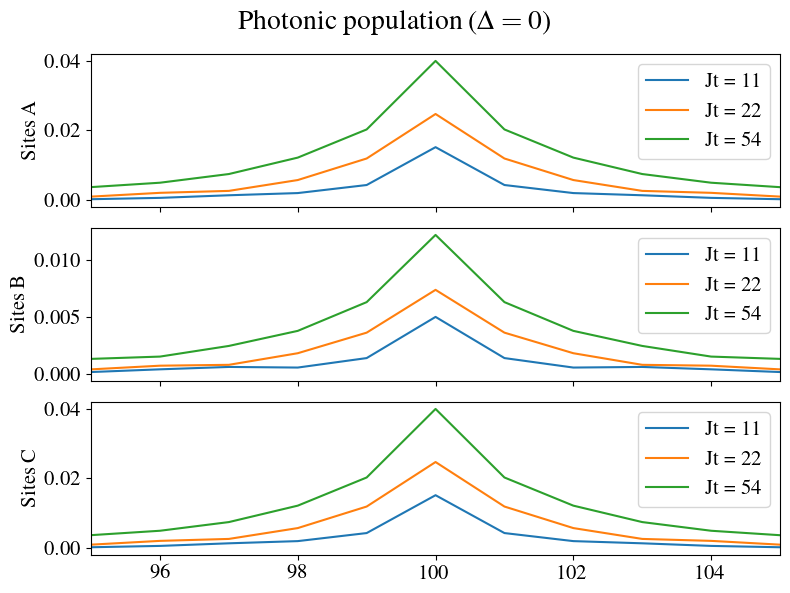

In [75]:
fig, ax = plt.subplots(figsize=(8,6),nrows=3,ncols=1,sharex=True,tight_layout=0)

for s in vec:
    ax[0].plot(pop_phot[::3,s],label=f"Jt = {t[s]:.0f}")
    ax[1].plot(pop_phot[1::3,s],label=f"Jt = {t[s]:.0f}")
    ax[2].plot(pop_phot[2::3,s],label=f"Jt = {t[s]:.0f}")

plt.suptitle(f"Photonic population ($\Delta = 0$)",fontsize=20)
#plt.xlabel("\# Site",fontsize=20)

#plt.xlim(95,104)
ax[0].set_ylabel("Sites A",fontsize=15)
ax[1].set_ylabel("Sites B",fontsize=15)
ax[2].set_ylabel("Sites C",fontsize=15)

#ax[0].set_ylim(0,2e-3)
#ax[1].set_ylim(0,2e-3)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)

ax[2].set_xlim(95,105)


#plt.savefig(f"plots/Asite/phot_A_{omega0*100:.0f}.png")

plt.show()

## Comparison

### Equal g, different $\omega_0$

In [152]:
omega0 = np.arange(1.5,2.51,0.1)
g = 0.1

In [153]:
t = [10.]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.30it/s]


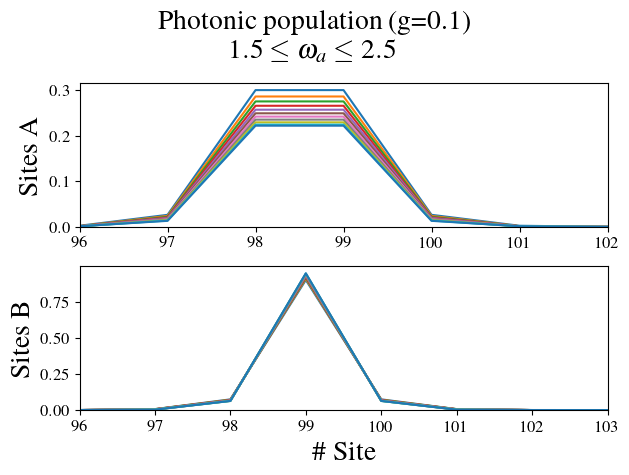

In [155]:
fig, ax = plt.subplots(nrows=2,ncols=1,tight_layout=True)

for s in range(len(omega0)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0[s],g,N-2)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax[0].plot(pop_phot[1::2,0],label=f"$\omega_0$ = {omega0[s]:.1f}")
    ax[1].plot(pop_phot[::2,0])


plt.suptitle(f"Photonic population (g={g:.1f})\n $1.5 \leq \omega_a \leq 2.5$",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax[0].set_xlim(96,102)
ax[1].set_xlim(96,103)
ax[0].set_ylim(0)
ax[1].set_ylim(0)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
#ax[0].legend()

plt.savefig("comp_omega_B.png")

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]


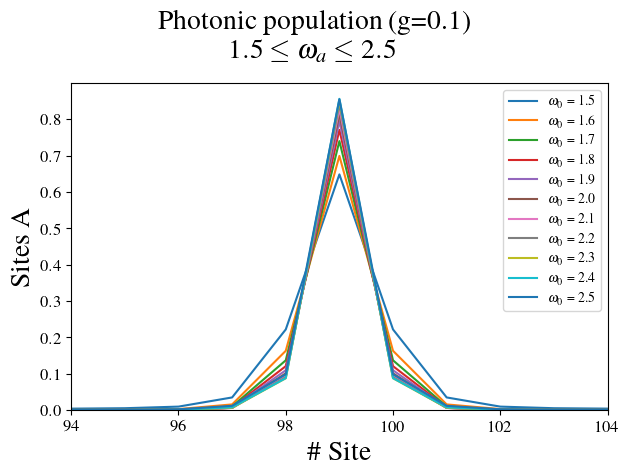

In [108]:
fig, ax = plt.subplots(tight_layout=True)

for s in range(len(omega0)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0[s],g,N-1)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax.plot(pop_phot[1::2,0],label=f"$\omega_0$ = {omega0[s]:.1f}")


plt.suptitle(f"Photonic population (g={g:.1f})\n $1.5 \leq \omega_a \leq 2.5$",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax.set_xlim(94,104)
ax.set_ylim(0)
ax.set_ylabel("Sites A",fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

plt.savefig("comp_omega2.png",dpi=400)

plt.show()

### Equal $\omega_0$, different g

In [156]:
omega0 = 2.
g = [0.01,0.05,0.07,0.1,0.15,0.2,0.3,0.4]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.53it/s]


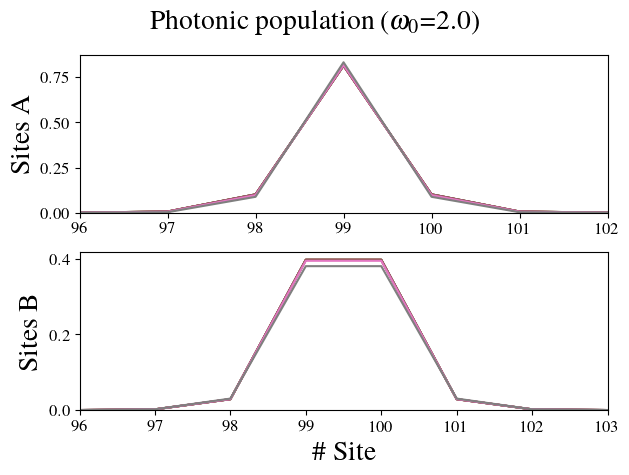

In [157]:
fig, ax = plt.subplots(nrows=2,ncols=1,tight_layout=True)

for s in range(len(g)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g[s],N-1)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax[0].plot(pop_phot[1::2,0],label=f"$g = {g[s]:.2f}")
    ax[1].plot(pop_phot[::2,0])


plt.suptitle(f"Photonic population ($\omega_0$={omega0:.1f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax[0].set_xlim(96,102)
ax[1].set_xlim(96,103)
ax[0].set_ylim(0)
ax[1].set_ylim(0)
ax[0].set_ylabel("Sites A",fontsize=20)
ax[1].set_ylabel("Sites B",fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
#ax[0].legend()

plt.savefig("comp_g.png")

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


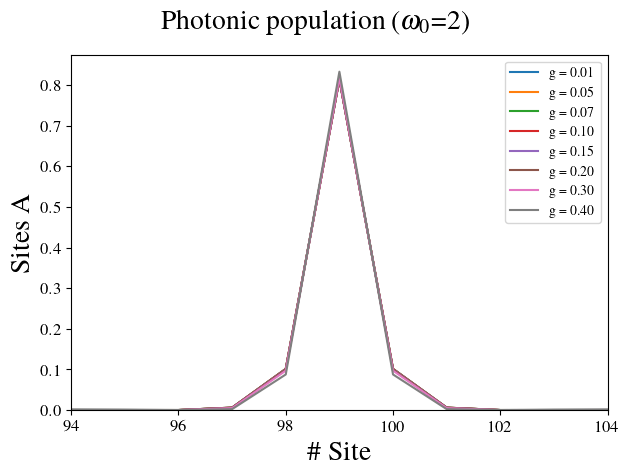

In [158]:
fig, ax = plt.subplots(tight_layout=True)

for s in range(len(g)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g[s],N-1)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax.plot(pop_phot[1::2,0],label=f"g = {g[s]:.2f}")


plt.suptitle(f"Photonic population ($\omega_0$={omega0:.0f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax.set_xlim(94,104)
ax.set_ylim(0)
ax.set_ylabel("Sites A",fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

plt.savefig("comp_g2.png",dpi=400)

plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


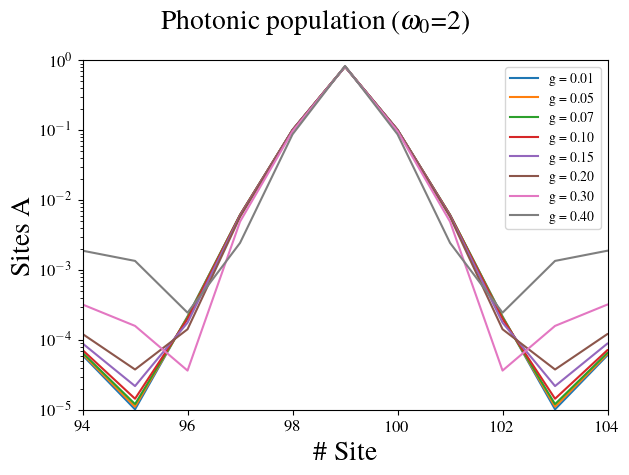

In [159]:
fig, ax = plt.subplots(tight_layout=True)

for s in range(len(g)):
    H = Ham_ST(N,eps_a,eps_b,t_aa,t_ab,t_bb,omega0,g[s],N-1)
    pop, phot = time_evol(t,H)
    
    pop_phot = np.zeros((n,len(t)))
    for i in range(len(t)):
        pop_phot[:,i] = np.real(phot[:,i]*np.conjugate(phot[:,i]))
        temp = norm(pop_phot[:,i])
        pop_phot[:,i] /= temp

    ax.plot(pop_phot[1::2,0],label=f"g = {g[s]:.2f}")


plt.suptitle(f"Photonic population ($\omega_0$={omega0:.0f})",fontsize=20)
plt.xlabel("\# Site",fontsize=20)

ax.set_xlim(94,104)
ax.set_ylim(1e-5,1)
#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Sites A",fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend()

plt.savefig("comp_g3.png",dpi=400)

plt.show()

In [147]:
def expo(x,a):
    
    return np.exp(-a*x)

In [148]:
popt,pcov = curve_fit(expo,z,pop_phot[199:208:2,0])

In [150]:
popt

array([2.29831024])

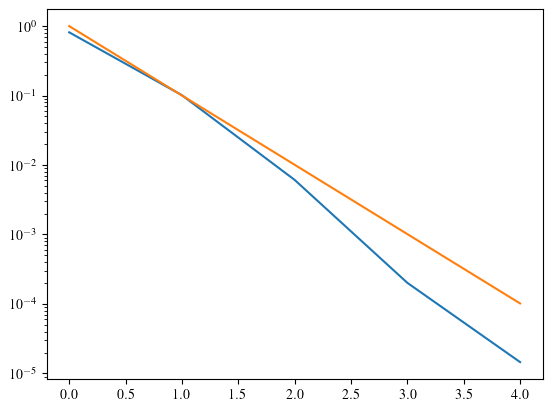

In [151]:
fig = plt.figure()

z = np.arange(0,5,1)
plt.plot(pop_phot[199:208:2,0])
plt.plot(np.exp(-popt*z))

plt.yscale("log")

plt.savefig("fit.png")
plt.show()